<a href="https://colab.research.google.com/github/klaragerlei/GoatsOfAllTime/blob/main/GLM_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using this device: ')
print(device)

Using this device: 
cpu


In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [4]:
import pandas as pd
import numpy as np


def assign_numbers_to_brain_areas(recording, brain_groups):
  # print('Areas in this recording:' + str(np.unique(recording['brain_area'])))
  nareas = len(brain_groups)
  NN = len(recording['brain_area']) # number of neurons
  barea = nareas * np.ones(NN, ) # last one is "other"
  for area_id in range(nareas):
    barea[np.isin(recording['brain_area'], brain_groups[area_id])] = area_id # assign a number to each region
  return barea


def get_firing_data_for_area(df_to_add_to, data, name_of_area, brain_groups):
  index_corresponding_to_area = np.where(brain_groups == name_of_area)[0][0]
  # print(index_corresponding_to_area)
  spikes = []
  for recording_id in range(len(data)):
    recording = data[recording_id]
    barea = assign_numbers_to_brain_areas(recording, brain_groups)
    spikes_in_recording = recording['spks'][barea==index_corresponding_to_area]
    # print(spikes_in_recording)
    spikes.append(spikes_in_recording)
  df_to_add_to['spikes'] = spikes
  return df_to_add_to


def load_behavioural_feature(df_to_add_to, data, column_name):
  features = []
  for recording_id in range(len(data)):  
    recording_data = data[recording_id]  # this is just one recording
    feature = recording_data[column_name]
    features.append(feature)
  df_to_add_to[column_name] = features
  return df_to_add_to

def drop_sessions_with_no_spikes(data_to_analyze):
  sessions_to_drop = []
  for session_index, session in data_to_analyze.iterrows():
    if len(session.spikes) == 0:
      sessions_to_drop.append(session_index)
  
  data_to_analyze = data_to_analyze.drop(sessions_to_drop, axis=0)
  return data_to_analyze


# Load firing data and behavioural variable for a given area
def load_data_for_model(brain_area, behavioural_feature, brain_groups):
  data_to_analyze = pd.DataFrame()  # make empty df
  # add behavioural feature to df
  data_to_analyze = load_behavioural_feature(data_to_analyze, alldat, behavioural_feature)
  # add spikes to df
  data_to_analyze = get_firing_data_for_area(data_to_analyze, alldat, brain_area, brain_groups)
  return data_to_analyze


def load_data(alldat, brain_area='MOp', feature='face'):
  brain_groups = np.array(["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl","CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM","CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST","ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT","APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI","ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI","BLA", "BMA", "EP", "EPd", "MEA"])
  data_to_analyze = load_data_for_model(brain_area=brain_area, behavioural_feature=feature, brain_groups=brain_groups)
  # data_to_analyze = load_data_for_model(brain_area=brain_area, behavioural_feature=behavioural_feature, brain_groups=brain_groups)
  data_to_analyze = drop_sessions_with_no_spikes(data_to_analyze)
  # print(data_to_analyze.head())
  return data_to_analyze


data_to_analyze = load_data(alldat)



In [5]:
def change_bin_size(array_in, window_size=10):
  array_with_different_bins = np.add.reduceat(array_in, range(0, len(array_in), window_size))
  return array_with_different_bins

#test_array = np.array([0, 1, 0, 0, 1, 0,3, 4, 5, 4, 1, 2, 3, 4, 5, 5, 0])
#print(test_array.shape)
#array_out = change_bin_size(test_array, window_size=10)
#print(test_array)
#print(array_out)

In [6]:
def convert_data_to_bigger_bin_size_spikes(data_to_analyze):
  spikes_big_bins = []
  for session_id, session in data_to_analyze.iterrows():
    spikes_in_session = []
    spikes = session.spikes
    for neuron in range(spikes.shape[0]):
      spikes_from_neuron = []
      spikes_neuron = spikes[neuron]
      spikes_all_trials = np.array(spikes_neuron.reshape(-1))
      spikes_new_bin_size = change_bin_size(spikes_all_trials, window_size=10)
      spikes_in_session.append(spikes_new_bin_size)
    spikes_big_bins.append(spikes_in_session)
  data_to_analyze['spikes_bigger_bins'] = spikes_big_bins
  print(data_to_analyze.spikes_bigger_bins)
  return data_to_analyze

data_to_analyze = convert_data_to_bigger_bin_size_spikes(data_to_analyze)

10    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
20    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...
28    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: spikes_bigger_bins, dtype: object


In [7]:
def convert_data_to_bigger_bin_size_face(data_to_analyze):
  face_data = []
  for session_id, session in data_to_analyze.iterrows():
    face_in_session = session.face
    face_data_flat = face_in_session.reshape(-1)
    face_new_bin_size = change_bin_size(face_data_flat, window_size=10)
    face_data.append(face_new_bin_size)
  data_to_analyze['face_bigger_bins'] = face_data
  return data_to_analyze

data_to_analyze = convert_data_to_bigger_bin_size_face(data_to_analyze)

In [8]:
def add_number_of_spikes_per_neuron_to_df(df):
  number_of_spikes = []
  for recording_index, recording in df.iterrows():
    spikes_all = recording.spikes
    spikes_neuron = []
    for neuron in range(spikes_all.shape[0]):
      num_of_spikes = np.sum(spikes_all[neuron])
      spikes_neuron.append(num_of_spikes)
    number_of_spikes.append(spikes_neuron)
  df['number_of_spikes'] = number_of_spikes
  return df      

data_to_analyze = add_number_of_spikes_per_neuron_to_df(data_to_analyze)

In [9]:
# plot spikes across time
def plot_spikes_across_time():
  session_id = 0
  neuron_id = 10
  # spikes_of_neuron = data_to_analyze.spikes[session_id][neuron_id]

  session_to_analyze = data_to_analyze.spikes.iloc[session_id]
  number_of_spikes = data_to_analyze.number_of_spikes.iloc[session_id][neuron_id]
  print('Number of spikes: ' + str(number_of_spikes))
  spikes_of_neuron = session_to_analyze.reshape(session_to_analyze.shape[0], -1)[neuron_id]
  plt.figure()
  plt.plot(spikes_of_neuron)
  plt.show()
  plt.close()

In [10]:
# plot pupil size
def plot_pupil_size():
  print(data_to_analyze.iloc[session_id].pupil.shape)
  pupil_data_to_plot_1 = data_to_analyze.pupil.iloc[session_id][1].T[0]
  pupil_data_to_plot_2 = data_to_analyze.pupil.iloc[session_id][2].T[0]
  print(pupil_data_to_plot.shape)
  plt.figure()
  plt.plot(pupil_data_to_plot_1)
  plt.show()
  plt.close()
  plt.figure()
  plt.plot(pupil_data_to_plot_2)
  plt.show()
  plt.close()

In [11]:
def reshape_pupil_data():
  # Make input features for model
  session_id = 0   # we will analyze this session
  session_to_analyze = data_to_analyze.spikes.iloc[session_id]
  print('number of spikes')
  print(data_to_analyze.number_of_spikes.iloc[session_id])
  print('Number of neurons in this session: ' + str(session_to_analyze.shape[0]))
  # try only one trial
  trial_id = 2
  session_to_analyze_reshaped = session_to_analyze[:,trial_id,:] # first trial 
  pupil_data = data_to_analyze.pupil.iloc[0][0,trial_id]  # first trial 

  print(session_to_analyze_reshaped.shape)
  print(pupil_data.shape)




In [12]:
  def reshape_face_data(data_to_analyze, session_id=0, trial_id=None):
    # Make input features for model
    session_to_analyze = data_to_analyze.spikes.iloc[session_id]
    print('number of spikes')
    print(data_to_analyze.number_of_spikes.iloc[session_id])
    print('Number of neurons in this session: ' + str(session_to_analyze.shape[0]))

    session_to_analyze_reshaped = session_to_analyze[-1] # all trials 
    face_data = data_to_analyze.face.iloc[session_id][0,-1]  # all trials

    if trial_id != None:
      session_to_analyze_reshaped = session_to_analyze[:,trial_id,:] # one trial 
      face_data = data_to_analyze.face.iloc[session_id][0,trial_id]  # one trial 


    print(session_to_analyze_reshaped.shape)
    print(face_data.shape)
    return face_data, session_to_analyze_reshaped
behaviour_data, session_to_analyze_reshaped = reshape_face_data(data_to_analyze, trial_id=None)

number of spikes
[4, 1784, 391, 8565, 204, 34, 4777, 301, 64, 5462, 0, 3077, 50, 51, 509, 2135, 141, 64, 5977, 5520, 484, 1822, 9, 79, 0, 287, 556, 41, 100, 14010, 114, 148, 174, 113, 1307, 5292, 147, 1849, 403, 691, 251, 5487, 93, 48, 2263, 59, 76, 100, 10227, 119, 454, 1676, 14, 253, 127, 1110, 1678, 1570, 130, 1812, 200, 117, 126, 7273, 129, 5138, 80, 301, 321, 24, 3637, 21, 5651, 4862, 28, 50, 723, 836, 1071, 50, 5002, 713, 35, 0, 187, 185, 2214, 11, 241, 1630, 2840, 275, 729, 2881, 185, 599, 136, 745, 14723, 217, 11110, 730, 267, 72, 130, 1636, 3669, 140, 1892, 118, 107, 41, 76, 8279, 895, 966, 68, 234, 80, 5509, 287, 6506, 7983, 303, 35, 137, 51, 41, 1265, 143, 180, 309, 1643, 287, 21338, 28892, 16645, 13582, 5876, 15118, 15296, 6715, 4707, 8655, 7542, 6413, 5596, 119, 10387, 5268, 2304, 1554, 1347, 3554, 9785, 140, 1719, 310, 23, 311, 607, 1657, 481, 17437, 1053, 43, 4900, 400, 1345, 6340, 44, 2809, 547, 440, 1845, 75, 1675, 2696, 1114, 321, 2708, 5707, 1953, 2710, 455, 873, 521

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV

def run_glm_with_original_bins(session_to_analyze_reshaped):
  model = RidgeCV(normalize=True)  # make ridge model

  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
  correlation_scores = cross_val_score(model, session_to_analyze_reshaped.T, behaviour_data, scoring='r2')   # 5-fold cross-validation
  print('Correlation scores with original bins:')
  print(correlation_scores)

run_glm_with_original_bins(session_to_analyze_reshaped)

Correlation scores with original bins:
[ -1.73134031  -4.62235856 -16.74417256  -3.47513471 -16.16781063]


In [14]:
# split data for test and training data sets
# USE THIS FOR DATA WITH BIG BINS
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV

def run_glm_with_bigger_bins(data_to_analyze, session_id=0):
  model = RidgeCV(normalize=True)  # make ridge model

  spikes = np.array(data_to_analyze.spikes_bigger_bins.iloc[session_id]).T
  face = data_to_analyze.face_bigger_bins.iloc[session_id]
  #print(spikes)
  #print(face)

  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
  correlation_scores = cross_val_score(model, spikes, face, scoring='r2')   # 5-fold cross-validation
  print('Correlation scores with bigger bins:')
  print(correlation_scores)

run_glm_with_bigger_bins(data_to_analyze)

Correlation scores with bigger bins:
[0.78212452 0.83345196 0.82893844 0.84781014 0.74611076]


# Plotting

### Non-Filtered (10ms bins version)

In [36]:
spikes_reshaped = data_to_analyze.spikes.iloc[0]
# spikes_reshaped.shape
spikes_reshaped = spikes_reshaped.reshape(spikes_reshaped.shape[0],(spikes_reshaped.shape[1]*spikes_reshaped.shape[2]))

spikes_reshaped.shape

(447, 85500)

In [37]:
face_reshaped = data_to_analyze.face.iloc[0]
# spikes_reshaped.shape
face_reshaped = face_reshaped.reshape(face_reshaped.shape[0],(face_reshaped.shape[1]*face_reshaped.shape[2])).squeeze()

face_reshaped.shape

(85500,)

In [38]:
# spikes_reshaped.shape

# # spikes = np.array(spikes_reshaped).T

# spikes.shape

In [39]:
#FOR PLOTTING

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV

data_to_analyze = data_to_analyze
session_id=0


model = RidgeCV(normalize=True)  # make ridge model

spikes = np.array(spikes_reshaped).T #Plot for smaller bins

face = face_reshaped #Plot for smaller bins

X_train, X_test, y_train, y_test = train_test_split(spikes, face, test_size=0.2, random_state=42) #Split between train and test


#print(spikes)
#print(face)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)


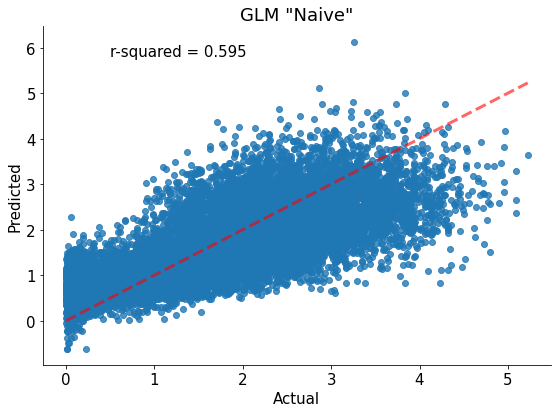

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y_test, y_pred, alpha =0.8)
# ax.plot(face, r2 * face + 0, 'r--', lw=3)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, alpha = 0.6)

ax.set_title('GLM "Naive"')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
# y_test, y_predicted = y_test.reshape(-1,1), y_predicted.reshape(-1,1)

ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)),(0.5,(y_pred.max()*0.95)))


plt.show()

### Filtered (100ms bins) version

In [42]:
#FOR PLOTTING

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV

data_to_analyze = data_to_analyze
session_id=0


model = RidgeCV(normalize=True)  # make ridge model

spikes = np.array(data_to_analyze.spikes_bigger_bins.iloc[session_id]).T #Plot for bigger bins

face = data_to_analyze.face_bigger_bins.iloc[session_id] #Plot for bigger bins

X2_train, X2_test, y2_train, y2_test = train_test_split(spikes, face, test_size=0.2, random_state=42) #Split between train and test


#print(spikes)
#print(face)

model.fit(X2_train, y2_train)

y2_pred = model.predict(X2_test)

from sklearn.metrics import r2_score
r2 = r2_score(y2_test, y2_pred)




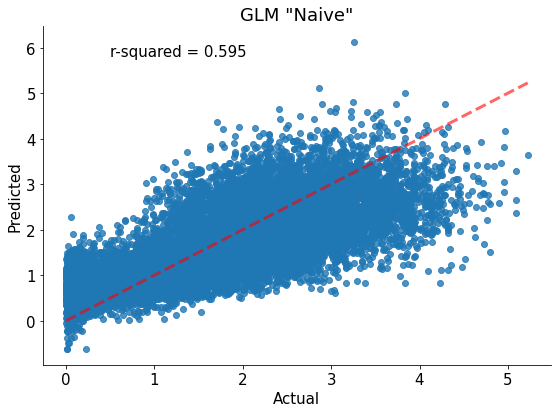

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y_test, y_pred, alpha =0.8)
# ax.plot(face, r2 * face + 0, 'r--', lw=3)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, alpha = 0.6)

ax.set_title('GLM "Naive"')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
# y_test, y_predicted = y_test.reshape(-1,1), y_predicted.reshape(-1,1)

ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)),(0.5,(y_pred.max()*0.95)))


plt.show()

### Both plots together

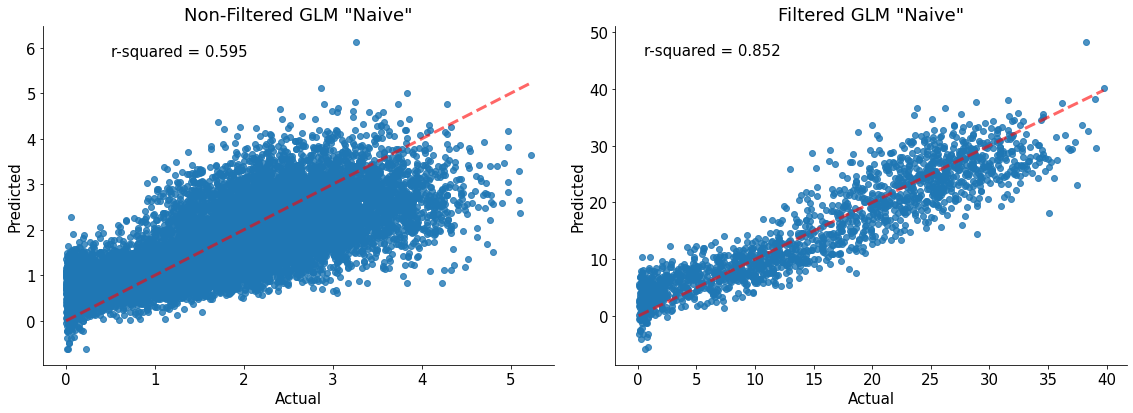

In [23]:
fig, ax = plt.subplots(1,2, figsize=(16,6))


ax[0].scatter(y_test, y_pred, alpha =0.8)
# ax.plot(face, r2 * face + 0, 'r--', lw=3)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, alpha = 0.6)

ax[0].set_title('Non-Filtered GLM "Naive"')
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
#regression line
# y_test, y_predicted = y_test.reshape(-1,1), y_predicted.reshape(-1,1)

ax[0].annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)),(0.5,(y_pred.max()*0.95)))

##########################################################################################################

ax[1].scatter(y2_test, y2_pred, alpha =0.8)
# ax.plot(face, r2 * face + 0, 'r--', lw=3)
ax[1].plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], 'r--', lw=3, alpha = 0.6)

ax[1].set_title('Filtered GLM "Naive"')
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')
#regression line
# y_test, y_predicted = y_test.reshape(-1,1), y_predicted.reshape(-1,1)

ax[1].annotate("r-squared = {:.3f}".format(r2_score(y2_test, y2_pred)),(0.5,(y2_pred.max()*0.95)))


plt.show()


fig.savefig('GLM_naives.svg')

# Plotting with the latents

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV

In [8]:
import json
import os

!pwd
import os
os.chdir('/content/')
!pwd

/content
/content


In [10]:
# import io
# import pandas as pd

from google.colab import files
uploaded = files.upload()

# Reading the json as a dict
with open('latent_variables_01.json') as json_data:
    df = json.load(json_data)


FileNotFoundError: ignored

In [46]:
def glm_for_latents(latents, targets):

  model = RidgeCV(normalize=True)  # make ridge model

  #The shape of the inputs are [Latents, trials*bins], and the outputs are [trials*bins]

  Latents = np.array(latents).T #Check the dimensionality to see which latents to take

  Targets = targets 

  X_train, X_test, y_train, y_test = train_test_split(Latents, Targets, test_size=0.2, random_state=42) #Split between train and test

  # The split is along the trials*bins axis, so the expected shapes are
  # X_train [%80 trials*bins, latents]
  # X_test [%20 trials*bins, latents]

  #print(spikes)
  #print(face)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  from sklearn.metrics import r2_score
  r2 = r2_score(y_test, y_pred)

  fig, ax = plt.subplots(figsize=(8,6))
  ax.scatter(y_test, y_pred, alpha =0.8)
  # ax.plot(face, r2 * face + 0, 'r--', lw=3)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, alpha = 0.6)

  ax.set_title('GLM "Latent"')
  ax.set_xlabel('Actual')
  ax.set_ylabel('Predicted')
  #regression line
  # y_test, y_predicted = y_test.reshape(-1,1), y_predicted.reshape(-1,1)

  ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)),(0.5,(y_pred.max()*0.95)))

  plt.show()
    

In [ ]:
# CHECK DIMENSIONS BEFORE, THE LATENTS EXPECT [Latents, trials*bins] AND THE TARGETS EXPECT [trials*bins]

# latents = 
# targets = 

glm_for_latents(latents, targets)